# Adaboost Model exploration


In [143]:
import numpy as np
from typing import Final, Optional, Tuple, List
import matplotlib.pyplot as plt
from utils.decision_stamp import DecisionStamp

In [145]:

tmp_data_path: Final = "./tests/data/test_dataset.csv"
tmp_matrix = np.genfromtxt(tmp_data_path, delimiter=",")[1:, :]
X, y, dist = tmp_matrix[:, :-2], tmp_matrix[:, -2], tmp_matrix[:, -1]


In [146]:
estimator = DecisionStamp()
estimator.fit(X, y, dist)
print(estimator.__dict__())
prediction = estimator.predict(X)
print(f"accuracy: {np.sum(prediction == y)/len(y)}")
print(f"weighted_error: {sum(dist[np.where(prediction != y)])}")

{'feature_index': 2, 'theta': -3.226097158243836, 'polarity': -1, 'weighted_error': 0.005476890177031034}
accuracy: 0.83
weighted_error: 0.0054768901770310754


In [161]:
from utils.new_ada_boost import AdaBoost
ada_est = AdaBoost(100)
dist_data = [[] for _ in range(len(dist))]
ada_est.fit(X, y, dist)
for est in ada_est.weak_est:
    for j in range(len(est.dist)):
        dist_data[j].append(est.dist[j])
    # print(f"feature index: {est.feature_index}")
dist_data = np.array(dist_data)

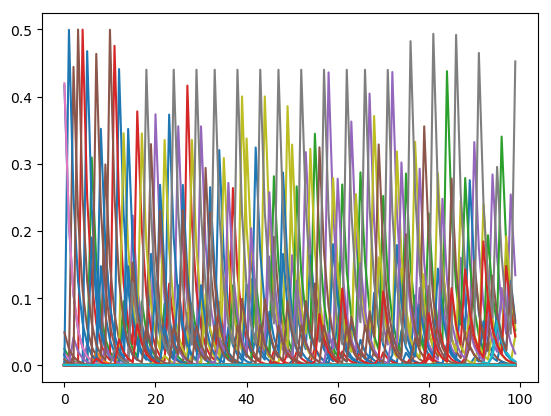

In [162]:
for i in range(100):
    plt.plot([j for j in range(len(dist_data[i]))], dist_data[i], label=f"dist {i}")
plt.show()

In [13]:
ada_est.__dict__()["weak_est"][1]

{'feature_index': 8,
 'theta': 3.2575291896486993,
 'polarity': -1,
 'weighted_error': 0.0029391633855682204}

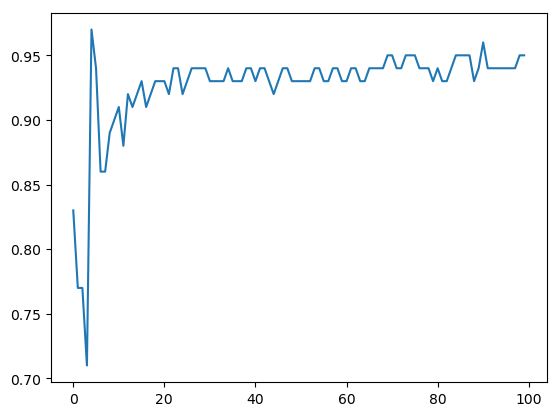

In [163]:
plt.plot(range(0, ada_est.num_of_est), ada_est.scores)
plt.show()

In [164]:
ada_est.save("new_model.json")
ada_est = AdaBoost.load("new_model.json")

In [8]:
weight_error_1 = ada_est.weak_est[0].weighted_error
beta_1 = weight_error_1/(1-weight_error_1)
alpha_1 = np.log(1/beta_1)

In [9]:
ada_est_1_prediction = (alpha_1*ada_est.weak_est[0].predict(X) >= alpha_1/2).astype(int)*2 - 1
weak_prediction = ada_est.weak_est[0].predict(X)

In [ ]:
ada_est = AdaBoost(5)
ada_est.fit(X, y*-1)
for est in ada_est.weak_est:
    print(f"feature index: {est.feature_index}")
print(ada_est.scores)

In [ ]:
print(np.sum(y == weak_prediction)/len(y))
print(np.sum(y == ada_est_1_prediction)/len(y))

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_dis(X, y, dist, j: int):
    sort_order = X[:,j].argsort()
    Xj =  (X[:,j])[sort_order]
    Yj =  (y)[sort_order]
    Dj = (dist)[sort_order]
    fig = plt.figure()
    fig.suptitle(f"{j} feature")
    ax1 = plt.subplot(221)
    ax1.scatter(Xj, np.multiply(Dj, Yj), alpha=0.5)
    ax2 = plt.subplot(222)
    ax2.scatter(Xj, Yj, color="red",alpha=0.5)
    fig.show()

for i in range(len(X[0, :])):
    plot_feature_dis(X, y, dist, i)

In [ ]:
import unittest

class TestAdaBoost(unittest.TestCase):
    """Test detect AdaBoost Classifier."""

    


unittest.main(argv=[''], verbosity=2, exit=False)

### Face Detection

In [15]:
import numpy as np
from typing import Final, Optional, Tuple, List

def load_file(file_path: str) -> np.ndarray:
    return np.loadtxt(file_path, dtype="int", delimiter=",")

In [1]:
test_dataset_path: Final = "../.tmp_dataset/test_data.csv"
test_matrix = load_file(test_dataset_path)
print(f"Test dataset shape: {test_matrix.shape}")

Test dataset shape: (2473, 25425)


In [16]:
train_dataset_path: Final = "../.tmp_dataset/train_data.csv"
train_matrix = load_file(train_dataset_path)
print(f"Train dataset shape: {train_matrix.shape}")

Train dataset shape: (2499, 25425)


In [ ]:
def distribution_normalization(dist: np.ndarray, labels: np.ndarray) -> np.ndarray:
    return dist/np.sum(dist)

def error_cal(predicted: np.ndarray, labels: np.ndarray, dis: np.ndarray) -> np.float32:
    return np.dot(np.abs(predicted - labels), dis).astype(np.float32)


In [17]:
X_train, y_train = train_matrix[:, :-1], train_matrix[:, -1]*2-1

In [18]:
from json import dump
from typing import Dict
from utils.new_ada_boost import AdaBoost
num_of_feature = 2
boost_clf = AdaBoost(num_of_feature)
boost_clf.fit(X_train, y_train)
ada_boost_dict = boost_clf.__dict__()

AttributeError: 'AdaBoost' object has no attribute 'alpha'

In [19]:
ada_boost_dict = boost_clf.__dict__()
with open(f"results/{num_of_feature}_ada_boost.json", "w") as fp:
    dump(ada_boost_dict, fp)

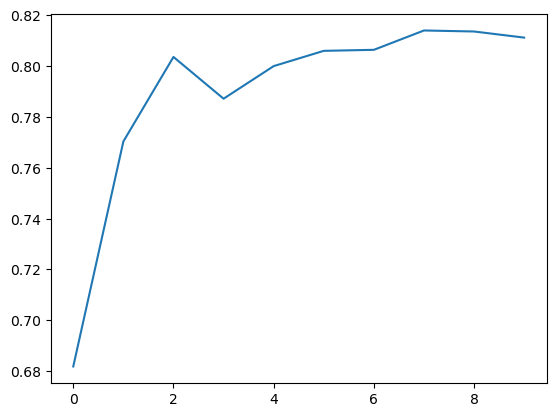

In [22]:
import matplotlib.pyplot as plt
plt.plot(range(0, boost_clf.num_of_est), boost_clf.scores)
plt.show()

In [24]:
for est in ada_boost_dict["weak_est"]:
    print(est["feature_index"])

8106
7960
7959
1530
7958
8108
19010
7924
7955
7942


### Haar Feature Visualization

In [300]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from utils.feature_extraction import get_integral_image


def show_image_side_by_side(image, i_image):
    fig = plt.figure()
    fig.suptitle(f"Integral and normal image")
    ax1 = plt.subplot(221)
    ax1.imshow(image, interpolation="none")
    ax2 = plt.subplot(222)
    ax2.imshow(i_image, interpolation="none")
    fig.show()

In [338]:
def get_sum_from_i_image(x, y, w, h, i_image):
    i_image_padded = np.pad(i_image, ((1,0), (1, 0)), constant_values=(0))
    A = i_image_padded[x, y]
    B = i_image_padded[x, y+w]
    C = i_image_padded[x+h, y]
    D = i_image_padded[x+h, y+w]
    return D + A - ( B + C )

def get_v_edge_feature(x, y, w, h, i_image):
    return get_sum_from_i_image(x, y, w, h, i_image) - get_sum_from_i_image(x, y+w, w, h, i_image)

def get_h_edge_feature(x, y, w, h, i_image):
    return get_sum_from_i_image(x, y, w, h, i_image) - get_sum_from_i_image(x+h, y, w, h, i_image)

def get_v_band_feature(x, y, w, h, i_image):
    white_area = (get_sum_from_i_image(x, y, w, h, i_image) + get_sum_from_i_image(x, y+2*w, w, h, i_image))
    black_area = get_sum_from_i_image(x, y+w, w, h, i_image)
    return  white_area - black_area 

def get_h_band_feature(x, y, w, h, i_image):
    white_area = (get_sum_from_i_image(x, y, w, h, i_image) + get_sum_from_i_image(x+2*h, y, w, h, i_image)) 
    black_area = get_sum_from_i_image(x+h, y, w, h, i_image)
    return white_area - black_area

def get_slant_edge_feature(x, y, w, h, i_image):
    white_area = (get_sum_from_i_image(x, y, w, h, i_image) + get_sum_from_i_image(x+h, y+w, w, h, i_image))
    black_area = (get_sum_from_i_image(x+h, y, w, h, i_image) + get_sum_from_i_image(x, y+w, w, h, i_image))
    return white_area - black_area 


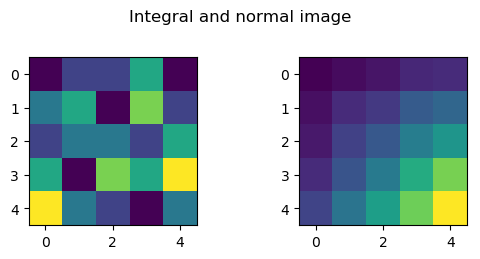

In [341]:
test_image = np.array([[1, 2, 2, 4, 1], [3, 4, 1, 5, 2], [2, 3, 3, 2, 4], [4, 1, 5, 4, 6], [6, 3, 2, 1, 3]])
test_i_image = get_integral_image(test_image)
show_image_side_by_side(test_image, test_i_image)

In [362]:
print(test_image)
print(test_i_image)
assert 10 == get_sum_from_i_image(0, 0, 2, 2, test_i_image)
assert 14 == get_sum_from_i_image(2, 2, 2, 2, test_i_image)
assert -2 == get_v_edge_feature(0, 0, 1, 2, test_i_image)
assert 0 == get_h_edge_feature(0, 0, 2, 2, test_i_image)
assert -3 == get_h_edge_feature(0, 1, 2, 2, test_i_image)
assert 0 == get_h_edge_feature(1, 1, 2, 2, test_i_image)
assert 1 == get_v_band_feature(0, 0, 1, 2, test_i_image)
assert 12 == get_v_band_feature(0, 1, 1, 2, test_i_image)
assert 1 == get_h_band_feature(0, 0, 2, 1, test_i_image)
assert 7 == get_h_band_feature(1, 0, 2, 1, test_i_image)
assert 2 == get_slant_edge_feature(0, 0, 2, 2, test_i_image)
assert 1 == get_slant_edge_feature(1, 1, 2, 2, test_i_image)

get_v_edge_feature(2, 1, 2, 2, test_i_image)

[[1 2 2 4 1]
 [3 4 1 5 2]
 [2 3 3 2 4]
 [4 1 5 4 6]
 [6 3 2 1 3]]
[[ 1.  3.  5.  9. 10.]
 [ 4. 10. 13. 22. 25.]
 [ 6. 15. 21. 32. 39.]
 [10. 20. 31. 46. 59.]
 [16. 29. 42. 58. 74.]]


-4.0

In [435]:
row, col = test_i_image.shape
filter_width, filter_height = 2, 3
max_width, max_height = col-2*filter_width+1, row-2*filter_height+1
print(col, row)
print(max_width, max_height)
for i in range(max_height):
    for j in range(max_width):
        print(i, j, get_slant_edge_feature(i, j, filter_width, filter_height, test_i_image))


5 6
2 1
0 0 -255.0
0 1 4.0


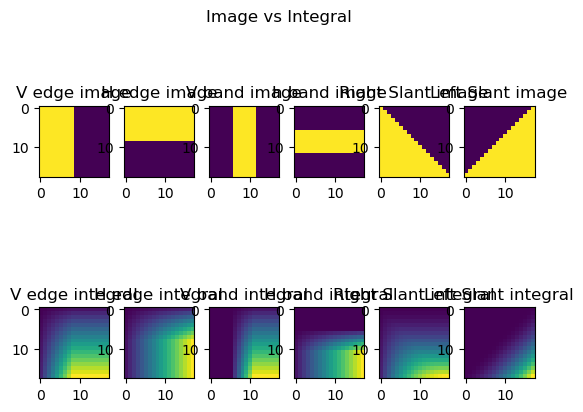

In [355]:
test_h_edge_image = np.array([[255]*162 + [0]*162]).reshape(18,18)
test_v_edge_image = np.array([[255]*162 + [0]*162]).reshape(18,18).T
test_h_band_image = np.array([0]*108 + [255]*108 + [0]*108 ).reshape(18, 18)
test_v_band_image = np.array([0]*108 + [255]*108 + [0]*108 ).reshape(18, 18).T
test_left_slant_image = np.rot90(np.tri(18, 18)*225).T
test_right_slant_image = (np.triu(np.ones((18, 18)))*225).T

test_h_edge_i_image = get_integral_image(test_h_edge_image)
test_v_edge_i_image = get_integral_image(test_v_edge_image)
test_h_band_i_image = get_integral_image(test_h_band_image)
test_v_band_i_image = get_integral_image(test_v_band_image)
test_left_slant_i_image = get_integral_image(test_left_slant_image)
test_right_slant_i_image = get_integral_image(test_right_slant_image)


fig, axes = plt.subplots(2, 6)
fig.suptitle("Image vs Integral")
axes[0, 0].imshow(test_v_edge_image)
axes[0, 0].title.set_text("V edge image")
axes[1, 0].imshow(test_v_edge_i_image)
axes[1, 0].title.set_text("V edge integral")
axes[0, 1].imshow(test_h_edge_image)
axes[0, 1].title.set_text("H edge image")
axes[1, 1].imshow(test_h_edge_i_image)
axes[1, 1].title.set_text("H edge integral")
axes[0, 2].imshow(test_v_band_image)
axes[0, 2].title.set_text("V band image")
axes[1, 2].imshow(test_v_band_i_image)
axes[1, 2].title.set_text("V band integral")
axes[0, 3].imshow(test_h_band_image)
axes[0, 3].title.set_text("h band image")
axes[1, 3].imshow(test_h_band_i_image)
axes[1, 3].title.set_text("H band integral")
axes[0, 4].imshow(test_right_slant_image)
axes[0, 4].title.set_text("Right Slant image")
axes[1, 4].imshow(test_right_slant_i_image)
axes[1, 4].title.set_text("Right Slant integral")
axes[0, 5].imshow(test_left_slant_image)
axes[0, 5].title.set_text("Left Slant image")
axes[1, 5].imshow(test_left_slant_i_image)
axes[1, 5].title.set_text("Left Slant integral")
plt.show()

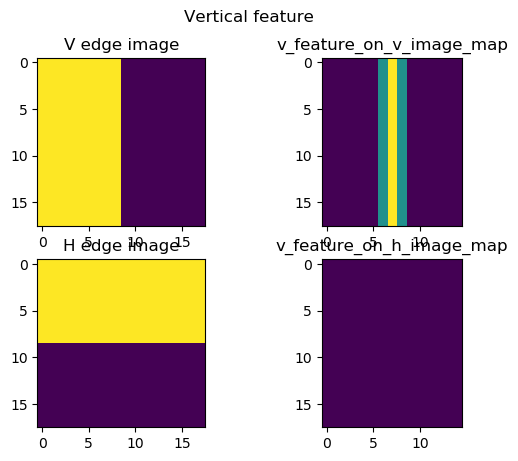

In [387]:
row, col = test_v_edge_i_image.shape
filter_width, filter_height = 2, 1
max_width, max_height = col-2*filter_width+1, row-1*filter_height+1
v_feature_on_v_image_map = np.zeros((max_height, max_width))
v_feature_on_h_image_map = np.zeros(( max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        v_feature_on_v_image_map[i, j] = get_v_edge_feature(i, j, filter_width, filter_height, test_v_edge_i_image)
for i in range(max_height):
    for j in range(max_width):
        v_feature_on_h_image_map[i, j] = get_v_edge_feature(i, j, filter_width, filter_height, test_h_edge_i_image)
fig, axes = plt.subplots(2, 2)
fig.suptitle("Vertical feature")
axes[0, 0].imshow(test_v_edge_image)
axes[0, 0].title.set_text("V edge image")
axes[0, 1].imshow(v_feature_on_v_image_map)
axes[0, 1].title.set_text("v_feature_on_v_image_map")
axes[1, 0].imshow(test_h_edge_image)
axes[1, 0].title.set_text("H edge image")
axes[1, 1].imshow(v_feature_on_h_image_map)
axes[1, 1].title.set_text("v_feature_on_h_image_map")
plt.show()

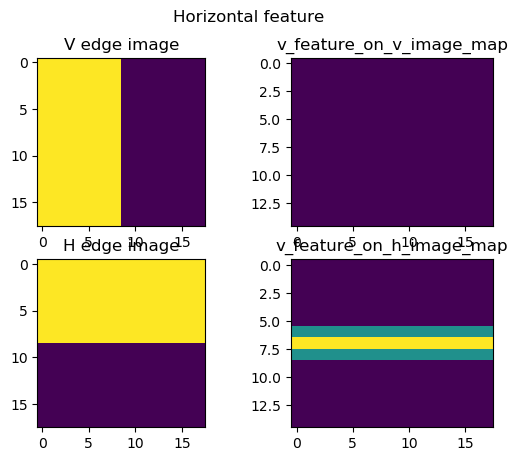

In [388]:
row, col = test_v_edge_i_image.shape
filter_width, filter_height = 1, 2
max_width, max_height = col-1*filter_width+1, row-2*filter_height+1
h_feature_on_v_image_map = np.zeros((max_height, max_width))
h_feature_on_h_image_map = np.zeros(( max_height, max_width))

for i in range(max_height):
    for j in range(max_width):
        h_feature_on_v_image_map[i, j] = get_h_edge_feature(i, j, filter_width, filter_height, test_v_edge_i_image)
for i in range(max_height):
    for j in range(max_width):
        h_feature_on_h_image_map[i, j] = get_h_edge_feature(i, j, filter_width, filter_height, test_h_edge_i_image)
fig, axes = plt.subplots(2, 2)
fig.suptitle("Horizontal feature")
axes[0, 0].imshow(test_v_edge_image)
axes[0, 0].title.set_text("V edge image")
axes[0, 1].imshow(h_feature_on_v_image_map)
axes[0, 1].title.set_text("v_feature_on_v_image_map")
axes[1, 0].imshow(test_h_edge_image)
axes[1, 0].title.set_text("H edge image")
axes[1, 1].imshow(h_feature_on_h_image_map)
axes[1, 1].title.set_text("v_feature_on_h_image_map")
plt.show()

13 17


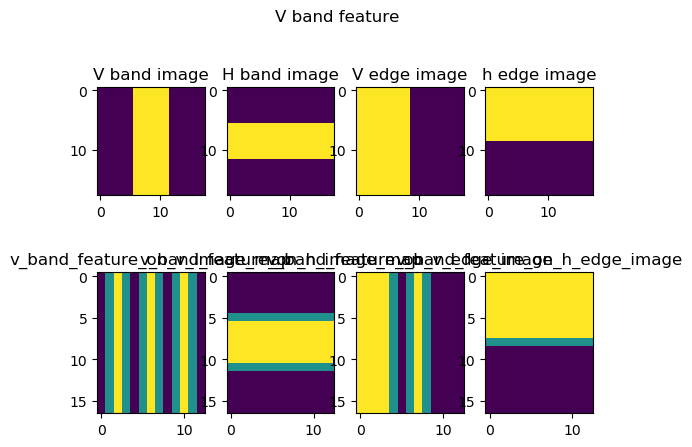

In [392]:
row, col = test_v_edge_i_image.shape
filter_width, filter_height = 2, 2
max_width, max_height = col-3*filter_width+1, row-1*filter_height+1
v_band_feature_on_v_image_map = np.zeros((max_height, max_width))
v_band_feature_on_h_image_map = np.zeros(( max_height, max_width))
v_band_feature_on_v_band_image_map = np.zeros((max_height, max_width))
v_band_feature_on_h_band_image_map = np.zeros(( max_height, max_width))

for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_v_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, test_v_edge_i_image)
for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_h_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, test_h_edge_i_image)
for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_v_band_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, test_v_band_i_image)

for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_h_band_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, test_h_band_i_image)

fig, axes = plt.subplots(2, 4)
fig.suptitle("V band feature")
axes[0, 0].imshow(test_v_band_image)
axes[0, 0].title.set_text("V band image")
axes[1, 0].imshow(v_band_feature_on_v_band_image_map)
axes[1, 0].title.set_text("v_band_feature_on_v_image_map")
axes[0, 1].imshow(test_h_band_image)
axes[0, 1].title.set_text("H band image")
axes[1, 1].imshow(v_band_feature_on_h_band_image_map)
axes[1, 1].title.set_text("v_band_feature_on_h_image_map")
axes[0, 2].imshow(test_v_edge_image)
axes[0, 2].title.set_text("V edge image")
axes[1, 2].imshow(v_band_feature_on_v_image_map)
axes[1, 2].title.set_text("v_band_feature_on_v_edge_image")
axes[0, 3].imshow(test_h_edge_image)
axes[0, 3].title.set_text("h edge image")
axes[1, 3].imshow(v_band_feature_on_h_image_map)
axes[1, 3].title.set_text("v_band_feature_on_h_edge_image")
plt.show()

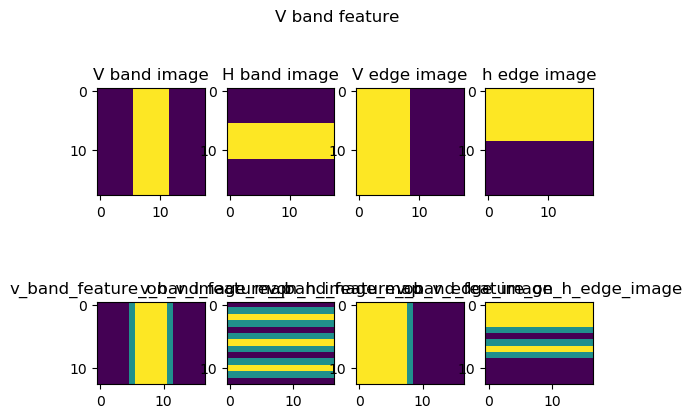

In [393]:
row, col = test_v_edge_i_image.shape
filter_width, filter_height = 2, 2
max_width, max_height = col-1*filter_width+1, row-3*filter_height+1
h_band_feature_on_v_image_map = np.zeros((max_height, max_width))
h_band_feature_on_h_image_map = np.zeros(( max_height, max_width))
h_band_feature_on_v_band_image_map = np.zeros((max_height, max_width))
h_band_feature_on_h_band_image_map = np.zeros(( max_height, max_width))

for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_v_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, test_v_edge_i_image)

for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_h_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, test_h_edge_i_image)

for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_v_band_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, test_v_band_i_image)

for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_h_band_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, test_h_band_i_image)

fig, axes = plt.subplots(2, 4)
fig.suptitle("V band feature")
axes[0, 0].imshow(test_v_band_image)
axes[0, 0].title.set_text("V band image")
axes[1, 0].imshow(h_band_feature_on_v_band_image_map)
axes[1, 0].title.set_text("v_band_feature_on_v_image_map")
axes[0, 1].imshow(test_h_band_image)
axes[0, 1].title.set_text("H band image")
axes[1, 1].imshow(h_band_feature_on_h_band_image_map)
axes[1, 1].title.set_text("v_band_feature_on_h_image_map")
axes[0, 2].imshow(test_v_edge_image)
axes[0, 2].title.set_text("V edge image")
axes[1, 2].imshow(h_band_feature_on_v_image_map)
axes[1, 2].title.set_text("v_band_feature_on_v_edge_image")
axes[0, 3].imshow(test_h_edge_image)
axes[0, 3].title.set_text("h edge image")
axes[1, 3].imshow(h_band_feature_on_h_image_map)
axes[1, 3].title.set_text("v_band_feature_on_h_edge_image")
plt.show()

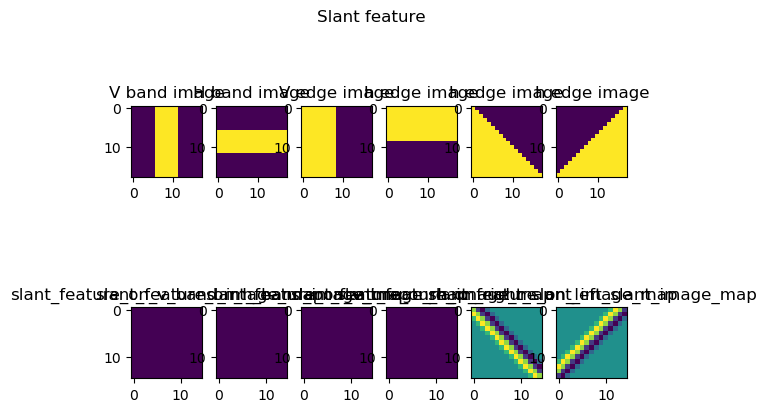

In [408]:
row, col = test_v_edge_i_image.shape

filter_width, filter_height = 2, 2
max_width, max_height = col-2*filter_width+1, row-2*filter_height+1


slant_feature_on_v_image_map = np.zeros((max_height, max_width))
slant_feature_on_h_image_map = np.zeros((max_height, max_width))
slant_feature_on_v_band_image_map = np.zeros((max_height, max_width))
slant_feature_on_h_band_image_map = np.zeros(( max_height, max_width))
slant_feature_on_left_slant_image_map = np.zeros((max_height, max_width))
slant_feature_on_right_slant_image_map = np.zeros((max_height, max_width))


for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_v_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_v_edge_i_image)

for i in range(max_width):
    for j in range(max_width):
        slant_feature_on_h_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_h_edge_i_image)

for i in range(max_width):
    for j in range(max_width):
        slant_feature_on_v_band_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_v_band_i_image)

for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_h_band_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_h_band_i_image)

for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_left_slant_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_left_slant_i_image)

for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_right_slant_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_right_slant_i_image)

fig, axes = plt.subplots(2, 6)
fig.suptitle("Slant feature")
axes[0, 0].imshow(test_v_band_image)
axes[0, 0].title.set_text("V band image")
axes[1, 0].imshow(slant_feature_on_v_band_image_map)
axes[1, 0].title.set_text("slant_feature_on_v_band_image_map")
axes[0, 1].imshow(test_h_band_image)
axes[0, 1].title.set_text("H band image")
axes[1, 1].imshow(slant_feature_on_h_band_image_map)
axes[1, 1].title.set_text("slant_feature_on_h_band_image_map")
axes[0, 2].imshow(test_v_edge_image)
axes[0, 2].title.set_text("V edge image")
axes[1, 2].imshow(slant_feature_on_v_image_map)
axes[1, 2].title.set_text("slant_feature_on_v_image_map")
axes[0, 3].imshow(test_h_edge_image)
axes[0, 3].title.set_text("h edge image")
axes[1, 3].imshow(slant_feature_on_h_image_map)
axes[1, 3].title.set_text("slant_feature_on_h_image_map")
axes[0, 4].imshow(test_right_slant_image)
axes[0, 4].title.set_text("h edge image")
axes[1, 4].imshow(slant_feature_on_right_slant_image_map)
axes[1, 4].title.set_text("slant_feature_on_right_slant_image_map")
axes[0, 5].imshow(test_left_slant_image)
axes[0, 5].title.set_text("h edge image")
axes[1, 5].imshow(slant_feature_on_left_slant_image_map)
axes[1, 5].title.set_text("slant_feature_on_left_slant_image_map")
plt.show()

Text(0.5,0.98,'Feature map on a face')

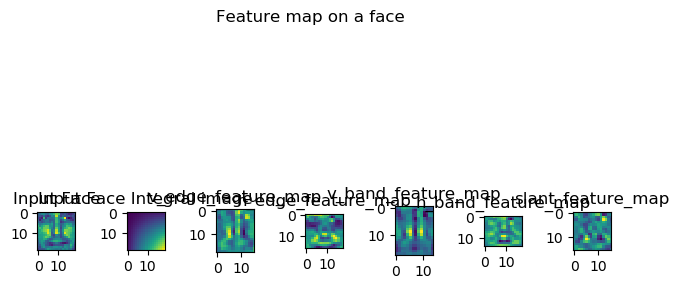

In [411]:
from typing import Final, Tuple
face_file: Final = "../dataset/trainset/faces/face00001.png"
image = imageio.imread(face_file)
i_image = get_integral_image(image)

feature_width, feature_height = 2, 2
row, col = i_image.shape

max_width, max_height = col-2*filter_width+1, row-1*filter_height+1
v_edge_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        v_edge_feature_on_face_image_map[i, j] = get_v_edge_feature(i, j, filter_width, filter_height, i_image)

max_width, max_height = col-1*filter_width+1, row-2*filter_height+1
h_edge_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        h_edge_feature_on_face_image_map[i, j] = get_h_edge_feature(i, j, filter_width, filter_height, i_image)

max_width, max_height = col-3*filter_width+1, row-1*filter_height+1
v_band_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_face_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, i_image)

max_width, max_height = col-1*filter_width+1, row-3*filter_height+1
h_band_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_face_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, i_image)

max_width, max_height = col-2*filter_width+1, row-2*filter_height+1
slant_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_face_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, i_image)

fig, axes = plt.subplots(1, 7)
fig.tight_layout()

axes[0].imshow(image, interpolation="none")
axes[0].title.set_text("Input Face")
axes[1].imshow(i_image, interpolation="none")
axes[1].title.set_text("Input Face Integral image")
axes[2].imshow(v_edge_feature_on_face_image_map, interpolation="none")
axes[2].title.set_text("v_edge_feature_map")
axes[3].imshow(h_edge_feature_on_face_image_map, interpolation="none")
axes[3].title.set_text("h_edge_feature_map")
axes[4].imshow(v_band_feature_on_face_image_map, interpolation="none")
axes[4].title.set_text("v_band_feature_map")
axes[5].imshow(h_band_feature_on_face_image_map, interpolation="none")
axes[5].title.set_text("h_band_feature_map")
axes[6].imshow(slant_feature_on_face_image_map, interpolation="none")
axes[6].title.set_text("slant_feature_map")
fig.suptitle("Feature map on a face")

### Haar Feature Extraction

In [119]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from utils.feature_extraction import get_integral_image

18 16
-256.0 276.0
18 14
188.0 886.0


/home/avashist/Viola-Jones_Algorithm/.env/lib/python3.8/site-packages/matplotlib/figure.py:456: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  warnings.warn(


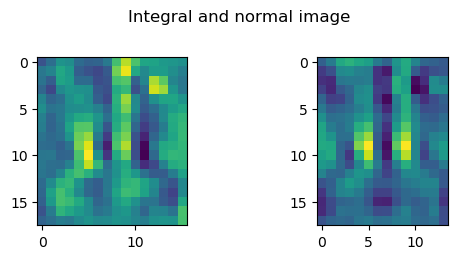

In [418]:
from typing import Final, Tuple
face_file: Final = "../dataset/trainset/faces/face00001.png"
image = imageio.imread(face_file)
i_image = get_integral_image(image)

filter_width, filter_height = 2, 2
image_width, image_height = i_image.shape
height_limit, width_limit = image_height-1*filter_height+1, image_width-2*filter_width+1

features = []
for i in range(height_limit):
    for j in range(width_limit):
        features.append(get_v_edge_feature(i, j, filter_width, filter_height, i_image))

v_edge_features = np.array(features).reshape((height_limit, width_limit))

print(height_limit, width_limit)
print(np.min(features), np.max(features))


filter_width, filter_height = 2, 2
image_width, image_height = i_image.shape
height_limit, width_limit = image_height-1*filter_height+1, image_width-3*filter_width+1

features = []
for i in range(height_limit):
    for j in range(width_limit):
        features.append(get_v_band_feature(i, j, filter_width, filter_height, i_image))
        
v_band_features = np.array(features).reshape((height_limit, width_limit))

print(height_limit, width_limit)
print(np.min(features), np.max(features))
show_image_side_by_side(v_edge_features, v_band_features)

In [428]:
print(image[:6, :6])
print(i_image[:9, :9])
print(v_edge_features[:5, :5])

print(f"V edge feature value: {get_v_edge_feature(0, 0, 2, 2, i_image)}")
print((104 + 122 + 90 + 102) - (142 + 159 + 116 + 120))
print(f"H band feature value: {get_h_band_feature(0, 0, 2, 2, i_image)}")
print((104 + 122 + 90 + 102) - (91 + 90 + 85 + 73) + (97 + 63 + 99 + 94))

[[104 122 142 159 162 158]
 [ 90 102 116 120 104  96]
 [ 91  90  81 102  81  74]
 [ 85  73  66 144  79 105]
 [ 97  63  88 100 108 110]
 [ 99  94  85  96 108 105]]
[[ 104.  226.  368.  527.  689.  847. 1014. 1191. 1376.]
 [ 194.  418.  676.  955. 1221. 1475. 1762. 2066. 2394.]
 [ 285.  599.  938. 1319. 1666. 1994. 2368. 2791. 3230.]
 [ 370.  757. 1162. 1687. 2113. 2546. 3022. 3546. 4091.]
 [ 467.  917. 1410. 2035. 2569. 3112. 3678. 4297. 4939.]
 [ 566. 1110. 1688. 2409. 3051. 3699. 4361. 5091. 5829.]
 [ 695. 1344. 2036. 2882. 3646. 4422. 5203. 6063. 6899.]
 [ 839. 1604. 2429. 3421. 4342. 5273. 6176. 7159. 8092.]
 [ 974. 1887. 2849. 3998. 5077. 6164. 7200. 8297. 9326.]]
[[-119.  -63.   17.    4.  -71.]
 [ -46.  -18.   64.   30.  -98.]
 [ -54.  -96.   54.   38.  -70.]
 [ -80. -141.   -4.   24.   14.]
 [ -16.  -82.  -62.   11.   39.]]
V edge feature value: -119.0
-119
H band feature value: 432.0
432


In [453]:
def feature_extraction(i_image: np.ndarray) -> np.ndarray:
    
    feature_val = []
    feature_para = []
    row, col = i_image.shape
    max_height, max_width = row+1, col//2+1
    
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row-1*feature_height+1, col-2*feature_width+1
            for i in range(0, height_limit):
                for j in range(0, width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_v_edge_feature(i, j, feature_width, feature_height, i_image))

    max_height, max_width = row//2+1, col+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row -2*feature_height+1, col -1*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_h_edge_feature(i, j, feature_width, feature_height, i_image))
            
    max_height, max_width = row+1, col//3+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row-1*feature_height+1, col-3*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_v_band_feature(i, j, feature_width, feature_height, i_image))

    max_height, max_width = row//3 + 1, col+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row-3*feature_height+1, col -1*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_h_band_feature(i, j, feature_width, feature_height, i_image))

    max_height, max_width = row//2+1, col//2+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row-2*feature_height+1, col-2*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_slant_edge_feature(i, j, feature_width, feature_height, i_image))

    return feature_val, feature_para


test_image = np.array([[1, 2, 2, 4, 1],
                    [3, 4, 1, 5, 2],
                    [2, 3, 3, 2, 4],
                    [4, 1, 5, 4, 6],
                    [6, 3, 2, 1, 3],
                    [255, 1, 2, 3, 4]], dtype=np.uint8)

test_i_image = get_integral_image(test_image)
feature_vales, feature_para = feature_extraction(i_image)
print(test_i_image.shape)
print(len(feature_vales))
print(test_i_image.shape)

(6, 5)
63960
(6, 5)


In [468]:
def get_feature_values(height: int, width: int, feature_index: int ) -> Optional[Tuple[int, int, int, int, str]]:
    val = 0
    max_height, max_width = height+1, width//2+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height-1*feature_height+1, width-2*feature_width+1
            for i in range(0, height_limit):
                for j in range(0, width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Vertical edge feature")
                    val += 1
    max_height, max_width = height//2+1, width+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height -2*feature_height+1, width -1*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Horizontal edge feature")
                    val += 1

    max_height, max_width = height+1, width//3+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height-1*feature_height+1, width -3*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Vertical band feature")
                    val += 1

    max_height, max_width = height//3+1, width+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height-3*feature_height+1, width -1*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Horizontal band feature")
                    val += 1

    max_height, max_width = height//2+1, width//2+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height-2*feature_height+1, width-2*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Slant feature")
                    val += 1

print(len(feature_para))
# print(get_feature_values(19, 19, 63959))

res = { 
        0: (0, 0, 1, 1, 'Vertical edge feature'),
        8988: (0, 8, 3, 16, 'Vertical edge feature'),
        17976: (12, 2, 1, 3, 'Horizontal edge feature'),
        26964: (3, 5, 7, 6, 'Horizontal edge feature'),
        35952: (4, 1, 1, 7, 'Vertical band feature'),
        44940: (0, 0, 6, 11, 'Vertical band feature'),
        53927: (14, 7, 12, 1, 'Horizontal band feature'),
        63927: (3, 1, 9, 6, 'Slant feature'),
        63959: (1, 1, 9, 9, 'Slant feature')
       }

for key in res.keys():
    print(feature_para[key])

63960
[0, 0, 1, 1]
[0, 8, 3, 16]
[12, 2, 1, 3]
[3, 5, 7, 6]
[4, 1, 1, 7]
[0, 0, 6, 11]
[14, 7, 12, 1]
[3, 1, 9, 6]
[1, 1, 9, 9]


In [457]:
feature_para[26964]

[3, 5, 7, 6]

In [101]:
feature_para[53927]

[1, 1, 9, 9]

In [99]:
for i in range(0, 53928, 53928//6):
    print(i, feature_para[i])

0 [0, 0, 1, 1]
8988 [14, 0, 4, 4]
17976 [8, 14, 2, 4]
26964 [8, 0, 10, 2]
35952 [4, 6, 3, 1]
44940 [6, 0, 13, 1]


10 12 2 5


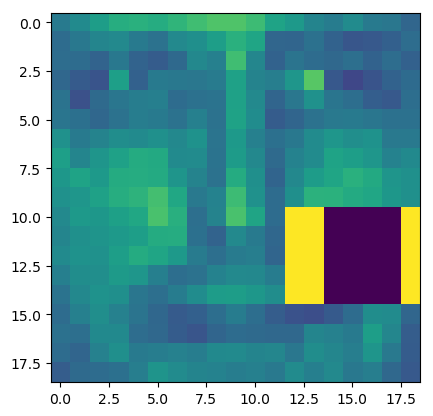

In [298]:
def draw_feature(base_image: np.ndarray, feature_index:int) -> np.ndarray:
    row, col = base_image.shape
    x, y, w, h, feature_type = get_feature_values(row, col, feature_index)
    print(x, y, w, h)
    # x, y = 0, 0
    if feature_type == "Vertical edge feature":
        base_image[x:x+h, y:y+w] = 255
        base_image[x:x+h, y+w:y+2*w] = 0

    elif feature_type == "Horizontal edge feature":
        base_image[x:x+h, y:y+w] = 255
        base_image[x+h:x+2*h, y:y+w] = 0
        
    elif feature_type == "Vertical band feature":
        base_image[x:x+h, y:y+w] = 255
        base_image[x:x+h, y+w:y+3*w] = 0
        base_image[x:x+h, y+3*w:y+4*w] = 255

    elif feature_type == "Horizontal band feature":
        base_image[x:x+h, y:y+w] = 255
        base_image[x+h:x+3*h, y:y+w] = 0
        base_image[x+3*h:x+4*w, y:y+w] = 255
    else:
        base_image[x:x+h, y:y+w] = 255
        base_image[x+h:x+2*h, y:y+w] = 0
        base_image[x:x+h, y+w:y+2*w] = 0
        base_image[x+h:x+2*h, y+w:y+2*w] = 255
        
        
    return base_image

face_file: Final = "../dataset/trainset/faces/face00001.png"
image = imageio.imread(face_file)

[33926, 34687, 47736]
fig = plt.figure()
plt.imshow(draw_feature(image.copy(), 34687))
fig.show()

7 6 2 3
1 3 2 4
13 4 2 3
10 10 2 2
3 13 3 2
13 12 3 2
8 11 2 2
1 7 2 6
13 6 2 5
13 10 4 2


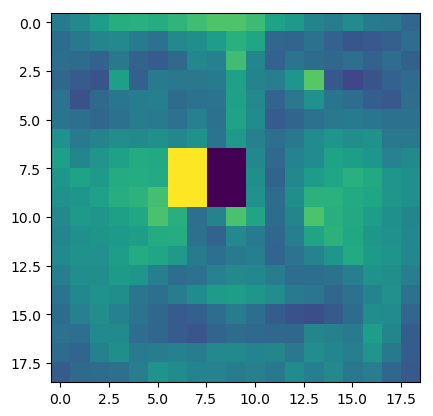

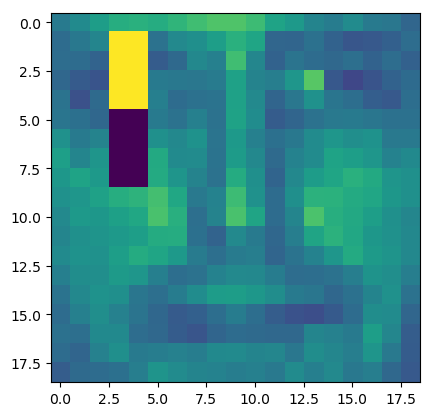

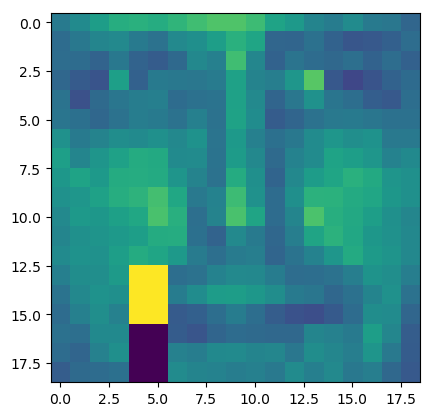

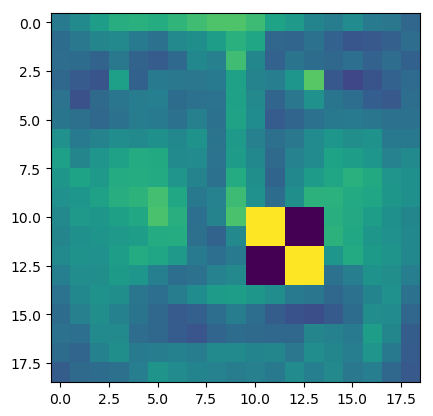

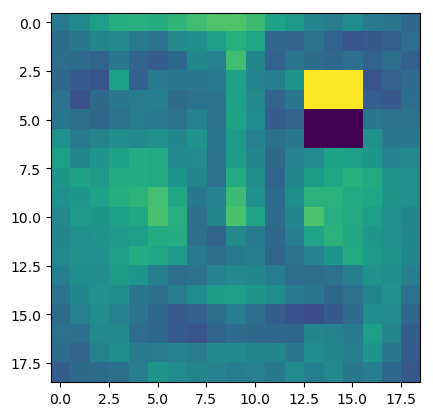

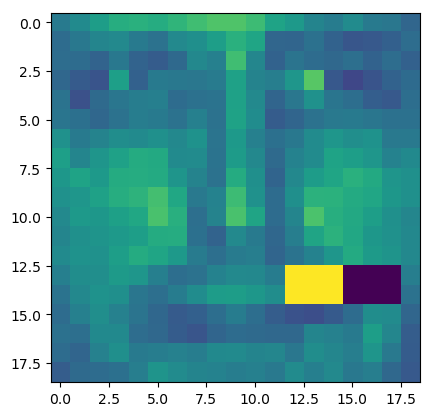

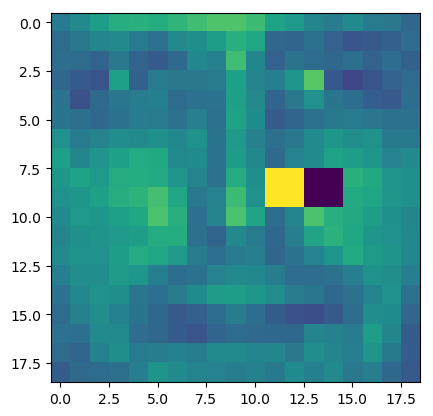

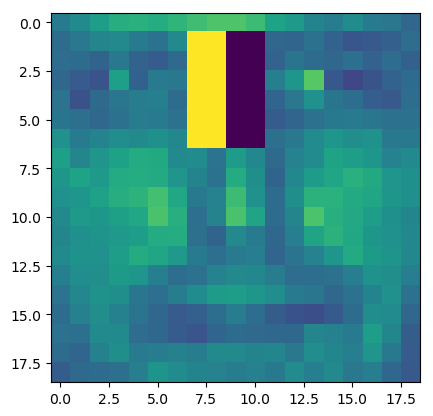

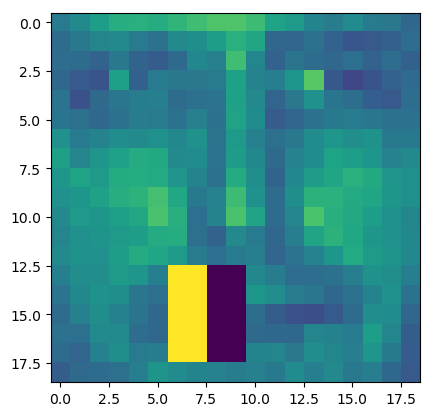

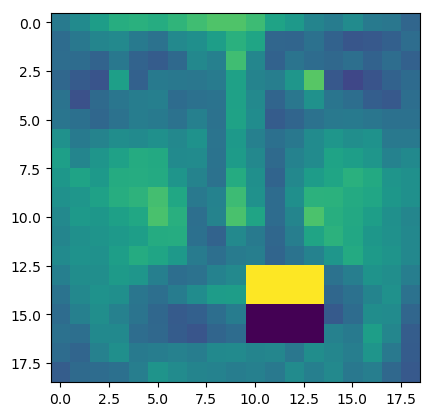

In [299]:
weak_est_data = [
        {
            "feature_index": 3756,
            "theta": -56.5,
            "polarity": 1,
            "weighted_error": 0.1503582164328616
        },
        {
            "feature_index": 17846,
            "theta": -237.5,
            "polarity": 1,
            "weighted_error": 0.1555237465497892
        },
        {
            "feature_index": 17813,
            "theta": -37.5,
            "polarity": 1,
            "weighted_error": 0.2018618963862876
        },
        {
            "feature_index": 47906,
            "theta": -21.5,
            "polarity": 1,
            "weighted_error": 0.21044946659573227
        },
        {
            "feature_index": 18889,
            "theta": -83.5,
            "polarity": 1,
            "weighted_error": 0.22824002773052174
        },
        {
            "feature_index": 6260,
            "theta": -38.5,
            "polarity": 1,
            "weighted_error": 0.26276839277893976
        },
        {
            "feature_index": 3505,
            "theta": -29.5,
            "polarity": 1,
            "weighted_error": 0.2730243679316027
        },
        {
            "feature_index": 4381,
            "theta": -118.5,
            "polarity": 1,
            "weighted_error": 0.2543410457049909
        },
        {
            "feature_index": 4348,
            "theta": -14.5,
            "polarity": 1,
            "weighted_error": 0.30685345682186005
        },
        {
            "feature_index": 20455,
            "theta": -64.0,
            "polarity": 1,
            "weighted_error": 0.29879602507265
        }
    ]

face_file: Final = "../dataset/trainset/faces/face00001.png"


for est in weak_est_data:
    image = imageio.imread(face_file)
    fig = plt.figure()
    plt.imshow(draw_feature(image.copy(), est["feature_index"]))
    fig.show